<a href="https://colab.research.google.com/github/rafahsa/video_emotion_analysis-/blob/main/acc99.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
import os

# عدّل اسم المجلد حسب مكان بياناتك في Google Drive
root_folder = '/content/drive/My Drive/my_data'

if not os.path.exists(root_folder):
    raise Exception("المجلد غير موجود! عدّل المسار حسب مكان مجلدك.")
else:
    print("عدد المجلدات/العناصر:", len(os.listdir(root_folder)))
    print("بعض العناصر:", os.listdir(root_folder)[:10])


عدد المجلدات/العناصر: 5
بعض العناصر: ['test', 'train', 'landmarks_train.csv', 'landmarks_test.csv', 'acc99.h5']


In [ ]:
!python -m pip install --upgrade pip
!python -m pip install numpy==1.26.4 mediapipe opencv-python tqdm


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.utils import to_categorical, Sequence
import matplotlib.pyplot as plt
print("كل شيء يعمل ✅")


كل شيء يعمل ✅


In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/My Drive/emotion_landmarks_with_videoid.csv')
print(df.shape)
print(df.head(3))


(5760, 1407)
       lm_0      lm_1      lm_2      lm_3      lm_4      lm_5      lm_6  \
0  0.486666  0.708056 -0.023230  0.479708  0.637997 -0.060528  0.485184   
1  0.486546  0.707184 -0.023601  0.480365  0.635598 -0.060622  0.485549   
2  0.487676  0.706039 -0.023175  0.481160  0.634378 -0.060576  0.486423   

       lm_7      lm_8      lm_9  ...   lm_1397   lm_1398   lm_1399   lm_1400  \
0  0.653610 -0.027651  0.472070  ... -0.024756  0.573169  0.471377 -0.016397   
1  0.651710 -0.027683  0.472728  ... -0.024204  0.574725  0.469979 -0.015662   
2  0.650673 -0.027512  0.473158  ... -0.024942  0.574632  0.469455 -0.016521   

    lm_1401   lm_1402   lm_1403    label                  video_id  \
0  0.579994  0.464311 -0.017762  disgust  01-01-07-02-02-01-07.mp4   
1  0.581541  0.462742 -0.017011  disgust  01-01-07-02-02-01-07.mp4   
2  0.581477  0.462037 -0.017842  disgust  01-01-07-02-02-01-07.mp4   

   frame_index  
0            0  
1            1  
2            2  

[3 rows x 1407 

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import mediapipe as mp
from tqdm import tqdm
import datetime

DATA_DIR = '/content/drive/MyDrive/my_data'
now = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
OUTPUT_CSV = f'/content/drive/MyDrive/emotion_landmarks_features_{now}.csv'
N_FRAMES = 5
IMG_SIZE = 128

mp_face_mesh = mp.solutions.face_mesh

def calc_eye_distance(landmarks):
    left_eye = np.array([landmarks[33][0], landmarks[33][1]])
    right_eye = np.array([landmarks[263][0], landmarks[263][1]])
    return np.linalg.norm(left_eye - right_eye)

def calc_face_width(landmarks):
    left = landmarks[234][:2]
    right = landmarks[454][:2]
    return np.linalg.norm(left - right)

def calc_nose_length(landmarks):
    top = landmarks[1][:2]
    bottom = landmarks[2][:2]
    return np.linalg.norm(top - bottom)



def calc_face_angle(landmarks):
    left_eye = np.array([landmarks[33][0], landmarks[33][1]])
    right_eye = np.array([landmarks[263][0], landmarks[263][1]])
    nose = np.array([landmarks[1][0], landmarks[1][1]])
    eye_center = (left_eye + right_eye) / 2
    vec = nose - eye_center
    angle = np.arctan2(vec[1], vec[0])
    return angle

data = []

for split in ['train', 'test']:
    split_path = os.path.join(DATA_DIR, split)
    emotions = [d for d in os.listdir(split_path) if os.path.isdir(os.path.join(split_path, d))]
    print(f"معالجة المجموعة: {split} - المشاعر: {emotions}")

    for emotion in emotions:
        emotion_path = os.path.join(split_path, emotion)
        video_files = [f for f in os.listdir(emotion_path) if f.lower().endswith(('.mp4', '.avi', '.mov'))]
        print(f"معالجة المشاعر: {emotion} - عدد الفيديوهات: {len(video_files)}")

        for video_file in tqdm(video_files, desc=f'Processing {emotion} videos in {split}'):
            video_path = os.path.join(emotion_path, video_file)
            cap = cv2.VideoCapture(video_path)
            if not cap.isOpened():
                print(f"خطأ في فتح الفيديو: {video_file}")
                continue

            with mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1) as face_mesh:
                frames_taken = 0
                frame_count = 0

                while frames_taken < N_FRAMES:
                    ret, frame = cap.read()
                    if not ret:
                        break

                    if frame_count % 1 == 0:
                        frame_resized = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
                        img_rgb = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2RGB)
                        results = face_mesh.process(img_rgb)

                        if results.multi_face_landmarks:
                            face_landmarks = results.multi_face_landmarks[0]
                            coords = []
                            for lm in face_landmarks.landmark:
                                coords.append([lm.x, lm.y, lm.z])

                            coords = np.array(coords)
                            center = coords[:, :2].mean(axis=0)
                            coords[:, :2] -= center
                            scale = np.linalg.norm(coords[:, :2], axis=1).max()
                            coords[:, :2] /= (scale + 1e-8)

                            eye_dist = calc_eye_distance(coords)
                            face_ang = calc_face_angle(coords)

                            row = coords.flatten().tolist()
                            row += [eye_dist, face_ang]
                            row += [emotion, video_file, frames_taken]

                            data.append(row)
                            frames_taken += 1
                    frame_count += 1

            cap.release()

print(f"عدد العينات المجمعة: {len(data)}")

if len(data) == 0:
    print("لم يتم جمع أي بيانات! تحقق من الفيديوهات ومساراتها وجودتها.")
else:
    num_landmarks = 468
    landmark_cols = []
    for i in range(num_landmarks):
        landmark_cols += [f'lm_{i}_x', f'lm_{i}_y', f'lm_{i}_z']

    feature_cols = ['eye_distance', 'face_angle']
    meta_cols = ['label', 'video_id', 'frame_index']

    columns = landmark_cols + feature_cols + meta_cols

    df = pd.DataFrame(data, columns=columns)
    df.to_csv(OUTPUT_CSV, index=False)
    print(f"تم حفظ بيانات landmarks والميزات في {OUTPUT_CSV}")


معالجة المجموعة: train - المشاعر: ['disgust', 'fearful', 'natural', 'calm', 'angry', 'happy', 'sad', 'superised']
معالجة المشاعر: disgust - عدد الفيديوهات: 20


Processing disgust videos in train: 100%|██████████| 20/20 [00:30<00:00,  1.51s/it]


معالجة المشاعر: fearful - عدد الفيديوهات: 20


Processing fearful videos in train: 100%|██████████| 20/20 [00:34<00:00,  1.74s/it]


معالجة المشاعر: natural - عدد الفيديوهات: 20


Processing natural videos in train: 100%|██████████| 20/20 [00:29<00:00,  1.48s/it]


معالجة المشاعر: calm - عدد الفيديوهات: 20


Processing calm videos in train: 100%|██████████| 20/20 [00:35<00:00,  1.76s/it]


معالجة المشاعر: angry - عدد الفيديوهات: 20


Processing angry videos in train: 100%|██████████| 20/20 [00:34<00:00,  1.71s/it]


معالجة المشاعر: happy - عدد الفيديوهات: 20


Processing happy videos in train: 100%|██████████| 20/20 [00:32<00:00,  1.62s/it]


معالجة المشاعر: sad - عدد الفيديوهات: 20


Processing sad videos in train: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


معالجة المشاعر: superised - عدد الفيديوهات: 20


Processing superised videos in train: 100%|██████████| 20/20 [00:27<00:00,  1.37s/it]


معالجة المجموعة: test - المشاعر: ['superised', 'angry', 'sad', 'happy', 'calm', 'disgust', 'fearful', 'natural']
معالجة المشاعر: superised - عدد الفيديوهات: 4


Processing superised videos in test: 100%|██████████| 4/4 [00:04<00:00,  1.21s/it]


معالجة المشاعر: angry - عدد الفيديوهات: 4


Processing angry videos in test: 100%|██████████| 4/4 [00:07<00:00,  1.93s/it]


معالجة المشاعر: sad - عدد الفيديوهات: 4


Processing sad videos in test: 100%|██████████| 4/4 [00:06<00:00,  1.54s/it]


معالجة المشاعر: happy - عدد الفيديوهات: 4


Processing happy videos in test: 100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


معالجة المشاعر: calm - عدد الفيديوهات: 4


Processing calm videos in test: 100%|██████████| 4/4 [00:04<00:00,  1.23s/it]


معالجة المشاعر: disgust - عدد الفيديوهات: 4


Processing disgust videos in test: 100%|██████████| 4/4 [00:05<00:00,  1.43s/it]


معالجة المشاعر: fearful - عدد الفيديوهات: 4


Processing fearful videos in test: 100%|██████████| 4/4 [00:05<00:00,  1.43s/it]


معالجة المشاعر: natural - عدد الفيديوهات: 4


Processing natural videos in test: 100%|██████████| 4/4 [00:06<00:00,  1.55s/it]


عدد العينات المجمعة: 960
تم حفظ بيانات landmarks والميزات في /content/drive/MyDrive/emotion_landmarks_features_20250605_210916.csv


sample_video: 01-01-02-02-01-01-15.mp4
sample_emotion: calm


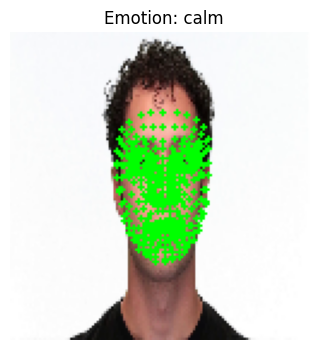

In [ ]:
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
import random
import os

# اختر فيديو عشوائي ومشاعر عشوائية من بياناتك
DATA_DIR = '/content/drive/MyDrive/my_data'
IMG_SIZE = 128

# عيّن اسم مجلد train والمشاعر واسم فيديو عشوائي
split = 'train'
split_path = os.path.join(DATA_DIR, split)
emotions = [d for d in os.listdir(split_path) if os.path.isdir(os.path.join(split_path, d))]
emotion = random.choice(emotions)
emotion_path = os.path.join(split_path, emotion)
video_files = [f for f in os.listdir(emotion_path) if f.lower().endswith(('.mp4', '.avi', '.mov'))]
video_file = random.choice(video_files)
video_path = os.path.join(emotion_path, video_file)

print("sample_video:", video_file)
print("sample_emotion:", emotion)

cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
cap.release()
if not ret:
    print("تعذر قراءة الصورة من الفيديو.")
else:
    # تصغير حجم الصورة للعرض فقط (اختياري)
    frame_resized = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))

    # تطبيق mediapipe مباشرة على الصورة (الصورة بدون تطبيع!)
    mp_face_mesh = mp.solutions.face_mesh
    with mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1) as face_mesh:
        img_rgb = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2RGB)
        results = face_mesh.process(img_rgb)

        if results.multi_face_landmarks:
            face_landmarks = results.multi_face_landmarks[0]
            # رسم نقاط الوجه على الصورة
            for lm in face_landmarks.landmark:
                # إحداثيات نسبية (بين 0 و 1)، نضربها بحجم الصورة
                x = int(lm.x * IMG_SIZE)
                y = int(lm.y * IMG_SIZE)
                cv2.circle(frame_resized, (x, y), 1, (0, 255, 0), -1)
            plt.figure(figsize=(4, 4))
            plt.title(f'Emotion: {emotion}')
            plt.imshow(cv2.cvtColor(frame_resized, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.show()
        else:
            print("لم يتم العثور على معالم وجه في هذه الصورة.")


✔️ X_seq (4032, 10, 1404), y_enc (4032,), classes 8
Class weights: {0: 0.9996458923512748, 1: 0.9996458923512748, 2: 0.9996458923512748, 3: 0.9996458923512748, 4: 0.9996458923512748, 5: 0.9996458923512748, 6: 1.0024857954545454, 7: 0.9996458923512748}
Train (2823, 10, 1404), Val (604, 10, 1404), Test (605, 10, 1404)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_1              │ (None, 10, 128)        │       179,840 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 320,712 (1.22 MB)

 Trainable params: 320,456 (1.22 MB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/60
89/89 - 4s - 42ms/step - accuracy: 0.2225 - loss: 2.1139 - val_accuracy: 0.3328 - val_loss: 1.8900 - learning_rate: 3.0000e-04
Epoch 2/60
89/89 - 1s - 13ms/step - accuracy: 0.3712 - loss: 1.7170 - val_accuracy: 0.4106 - val_loss: 1.7201 - learning_rate: 3.0000e-04
Epoch 3/60
89/89 - 1s - 15ms/step - accuracy: 0.4874 - loss: 1.4461 - val_accuracy: 0.5613 - val_loss: 1.4480 - learning_rate: 3.0000e-04
Epoch 4/60
89/89 - 1s - 10ms/step - accuracy: 0.5742 - loss: 1.2283 - val_accuracy: 0.6126 - val_loss: 1.2182 - learning_rate: 3.0000e-04
Epoch 5/60
89/89 - 1s - 13ms/step - accuracy: 0.6596 - loss: 1.0190 - val_accuracy: 0.7318 - val_loss: 0.9435 - learning_rate: 3.0000e-04
Epoch 6/60
89/89 - 1s - 10ms/step - accuracy: 0.7237 - loss: 0.8285 - val_accuracy: 0.7748 - val_loss: 0.7364 - learning_rate: 3.0000e-04
Epoch 7/60
89/89 - 1s - 13ms/step - accuracy: 0.8098 - loss: 0.6454 - val_accuracy: 0.8411 - val_loss: 0.5714 - learning_rate: 3.0000e-04
Epoch 8/60
89/89 - 1s - 14ms/step 

<Figure size 600x600 with 0 Axes>

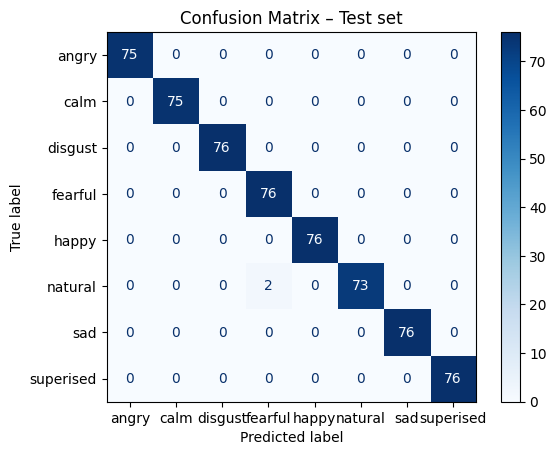

In [ ]:
import os, numpy as np, pandas as pd, gc

CSV_PATH = '/content/drive/My Drive/emotion_landmarks_with_videoid.csv'
LABEL_COL = 'label'
VID_COL   = 'video_id'
FRAME_COL = 'frame_index'
N_FRAMES  = 10

if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"لم أجد الملف عند {CSV_PATH}. عدّل المسار أو ارفع CSV الصحيح.")

df = pd.read_csv(CSV_PATH)

lm_cols = [c for c in df.columns if c.startswith('lm_')]
if not lm_cols:
    raise ValueError("لم أجد أعمدة تبدأ بـ 'lm_'. تأكد من اسم الأعمدة فى ملفك.")

X_list, y_list = [], []
for _, grp in df.groupby(VID_COL):
    grp = grp.sort_values(FRAME_COL)
    frames = grp[lm_cols].values.astype('float32')
    # 1️⃣ تقييس لكل فريم (feature‑wise)
    frames = (frames - frames.mean(axis=0)) / (frames.std(axis=0) + 1e-6)
    label  = grp[LABEL_COL].iloc[0]
    for i in range(0, len(frames) - N_FRAMES + 1):
        X_list.append(frames[i:i+N_FRAMES])
        y_list.append(label)

X_seq = np.stack(X_list)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder(); y_enc = le.fit_transform(y_list)
num_classes = len(le.classes_)
print(f"✔️ X_seq {X_seq.shape}, y_enc {y_enc.shape}, classes {num_classes}")

# ------------------------------------------------
# 1) تقسيم البيانات 70/15/15
# ------------------------------------------------
from sklearn.model_selection import train_test_split
TEST_SIZE, VAL_FRAC, SEED = 0.15, 0.176, 42

X_temp, X_test, y_temp, y_test = train_test_split(X_seq, y_enc,
    test_size=TEST_SIZE, random_state=SEED, stratify=y_enc)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp,
    test_size=VAL_FRAC, random_state=SEED, stratify=y_temp)

from sklearn.utils.class_weight import compute_class_weight
cw = compute_class_weight('balanced', classes=np.arange(num_classes), y=y_train)
class_weights = {i: w for i, w in enumerate(cw)}
print("Class weights:", class_weights)

from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes)
y_val   = to_categorical(y_val,   num_classes)
y_test  = to_categorical(y_test,  num_classes)

print(f"Train {X_train.shape}, Val {X_val.shape}, Test {X_test.shape}")

# ------------------------------------------------
# 2) tf.data.Dataset
# ------------------------------------------------
import tensorflow as tf
BATCH = 32

def make_ds(X, y, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(X), seed=SEED)
    return ds.batch(BATCH).prefetch(tf.data.AUTOTUNE)

train_ds = make_ds(X_train, y_train, shuffle=True)
val_ds   = make_ds(X_val,   y_val)
test_ds  = make_ds(X_test,  y_test)

del X_train, X_val, X_test, y_train, y_val, y_test, X_seq; gc.collect()

# ------------------------------------------------
# 3) نموذج جديد: إسقاط 128 + LSTM 128
# ------------------------------------------------
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, TimeDistributed

model = Sequential([
    TimeDistributed(Dense(128, activation='relu'), input_shape=(N_FRAMES, len(lm_cols))),
    LSTM(128),
    BatchNormalization(),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.1),
    Dense(num_classes, activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(3e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

# ------------------------------------------------
# 4) التدريب
# ------------------------------------------------
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau('val_loss', patience=6, factor=0.5),
    tf.keras.callbacks.EarlyStopping('val_loss', patience=12, restore_best_weights=True)
]

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=60,
                    callbacks=callbacks,
                    class_weight=class_weights,
                    verbose=2)

train_ds = val_ds = None; gc.collect()

# ------------------------------------------------
# 5) التقييم
# ------------------------------------------------
probs = model.predict(test_ds, verbose=0)
y_pred = np.argmax(probs, axis=1)
y_true = np.argmax(np.concatenate([y for _, y in test_ds], axis=0), axis=1)

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
print('\nClassification Report (Test):\n')
print(classification_report(y_true, y_pred, target_names=le.classes_, digits=4))

cm = confusion_matrix(y_true, y_pred)
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
ConfusionMatrixDisplay(cm, display_labels=le.classes_).plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix – Test set')
plt.show()


In [ ]:
MODEL_PATH = '/content/drive/My Drive/my_data/acc99.h5'
model.save(MODEL_PATH)
print(f"✅ Model saved to {MODEL_PATH}")


✅ Model saved to /content/drive/My Drive/my_data/acc99.h5


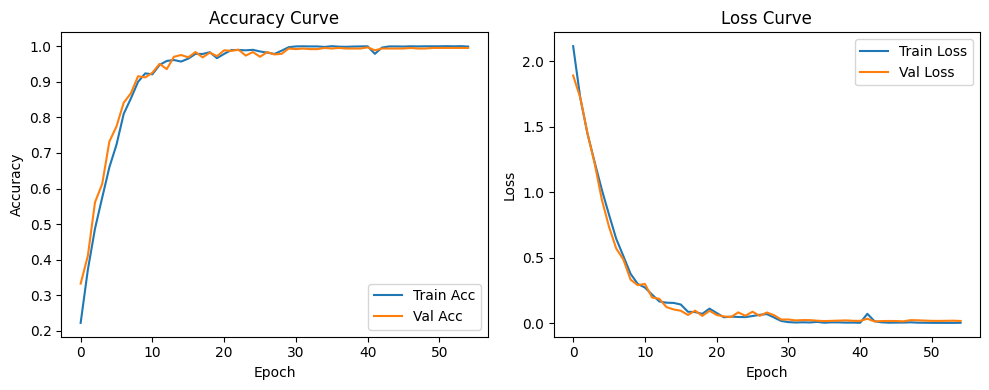

In [ ]:
# 6) رسم منحنيات التعلم (Learning Curves)
# ------------------------------------------------
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy Curve'); plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss Curve'); plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
print(window.shape)  # يجب (1, 10, 1404)
print(window.mean(), window.std())  # تقريباً 0 و 1


(1, 10, 1404)
-2.1214498e-06 0.9979669


In [ ]:
!apt-get -y install ffmpeg


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [ ]:
# --------- حساب الإحصاءات العالمية وحفظها ---------
import numpy as np, pandas as pd

CSV_PATH = '/content/drive/My Drive/emotion_landmarks_with_videoid.csv'
N_FRAMES = 10                                                       # نفس قيمة التدريب
lm_cols  = [c for c in pd.read_csv(CSV_PATH, nrows=1).columns if c.startswith('lm_')]

df = pd.read_csv(CSV_PATH)[lm_cols].astype('float32')
feat_mean = df.values.mean(axis=0)
feat_std  = df.values.std(axis=0)
np.save('/content/feat_mean.npy', feat_mean)
np.save('/content/feat_std.npy',  feat_std)
print('✅ Saved feat_mean.npy & feat_std.npy')


✅ Saved feat_mean.npy & feat_std.npy


In [ ]:
# =========================  خلية اختبار فيديو خارجي  =========================
VIDEO_PATH   = '/content/drive/MyDrive/surprised_bsher.mp4'       # ← مسار الفيديو الذي تريد اختباره
MODEL_PATH   = '/content/drive/My Drive/my_data/acc99.h5'             # ← الموديل الذي حفظته
MEAN_PATH    = '/content/feat_mean.npy'        # ← ملف المتوسط المحفوظ أثناء التدريب
STD_PATH     = '/content/feat_std.npy'         # ← ملف الانحراف المعياري
OUTPUT_PATH  = '/content/annotated_video.mp4'  # ← اسم ملف الإخراج
N_FRAMES     = 10                              # يجب أن يطابق قيمة التدريب

# --------------------------------------------------------------------------- #
import os, subprocess, cv2, numpy as np, mediapipe as mp, tensorflow as tf
from tensorflow.keras.models import load_model

# 😎 تحميل الموديل والإحصاءات
model      = load_model(MODEL_PATH)
feat_mean  = np.load(MEAN_PATH)
feat_std   = np.load(STD_PATH)
le_classes = np.array(['angry','calm','disgust','fearful',
                       'happy','natural','sad','superised'])


# 🎥 إعداد قراءة الفيديو والكتابة
cap = cv2.VideoCapture(VIDEO_PATH)
fps = cap.get(cv2.CAP_PROP_FPS) or 25
w,  h  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
tmp_no_audio = 'tmp_no_audio.mp4'
writer = cv2.VideoWriter(tmp_no_audio, fourcc, fps, (w, h))

# 🖐 تهيئة MediaPipe FaceMesh
mp_face = mp.solutions.face_mesh.FaceMesh(static_image_mode=False, refine_landmarks=False)

seq_buffer, preds = [], []
while True:
    ret, frame = cap.read()
    if not ret: break

    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    res = mp_face.process(rgb)

    if res.multi_face_landmarks:
        lm = res.multi_face_landmarks[0]
        # ✨ استخدم أول 468 نقطة (468×3 = 1404) مثل التدريب
        coords = np.array([[p.x, p.y, p.z] for p in lm.landmark[:468]], dtype=np.float32).flatten()
        coords = (coords - feat_mean) / (feat_std + 1e-6)        # نفس التطبيع
        seq_buffer.append(coords)

        if len(seq_buffer) == N_FRAMES:
            window = np.stack(seq_buffer, axis=0)[None, ...]     # (1, N_FRAMES, 1404)
            pred_idx = model.predict(window, verbose=0).argmax()
            label    = le_classes[pred_idx]
            preds.append(pred_idx)
            seq_buffer.pop(0)                                    # انزِل للإطارات التالية

            cv2.putText(frame, label, (30, 60), cv2.FONT_HERSHEY_SIMPLEX,
                        2, (0, 255, 0), 4, cv2.LINE_AA)

    writer.write(frame)

cap.release(); writer.release(); mp_face.close()

# 🔊 دمج الصوت الأصلي مع الفيديو المعلَّق
subprocess.run([
    'ffmpeg', '-y',
    '-i', tmp_no_audio, '-i', VIDEO_PATH,
    '-c', 'copy', '-map', '0:v:0', '-map', '1:a:0', OUTPUT_PATH
], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
os.remove(tmp_no_audio)

print(f'✅ Annotated video saved to {OUTPUT_PATH}')
if preds:
    majority = le_classes[np.bincount(preds).argmax()]
    print(f'🔎 Majority prediction for the clip: {majority}')
# ============================================================================ #


✅ Annotated video saved to /content/annotated_video.mp4
🔎 Majority prediction for the clip: disgust
